# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

***

# 1. Pricing the Callable Bond

### Data

Use the data from the following files.
* `../data/callable_bonds_2025-02-13.xlsx`
* `../data/discount_curve_2025-02-13.xlsx`

The data contains info on the following bonds.

`Callable`
* `FHLMC 4.41 01/28/30` is a callable bond, and it is the primary object of our analysis.

`Reference` bonds for a forward price.
* `FHLMC 0.97 01/28/28`
* `FHLMC 1.25 01/29/30`

Though these are technically callable, they are far out of the money. Thus, for the purposes of this analysis, we consider the reference bonds as non-callable bonds.

These reference bonds are analyzed in optional problems at the end, but mostly you will focus on the `callable` bond.

In [31]:
FILE_BOND = '../../data/callable_bonds_2025-02-13.xlsx'
FILE_CURVE = '../../data/discount_curve_2025-02-13.xlsx'

KEY_CALLABLE = 'FHLMC 4.41 01/28/30'
KEY_REF_T1 = 'FHLMC 0.97 01/28/28'
KEY_REF_T2 = 'FHLMC 1 1/4 01/29/30'

### Bond Info

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


info = pd.read_excel(FILE_BOND,sheet_name='info').set_index('info')
info.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call"], :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


### Quoted Values

In [33]:
quotes = pd.read_excel(FILE_BOND,sheet_name='quotes').set_index('quotes')
quotes.style.format('{:.2f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13,2025-02-13,2025-02-13
TTM,2.95,4.96,4.96
Clean Price,90.14,85.11,99.89
Dirty Price,90.19,85.16,100.09
Accrued Interest,0.04,0.05,0.20
YTM Call,54.24,85.40,4.45
YTM Maturity,4.57,4.65,4.43
Duration,2.92,4.81,4.50
Modified Duration,2.85,4.70,4.40


### Discount Curves

In [52]:
discs = pd.read_excel(FILE_CURVE,sheet_name='discount curve').set_index('ttm')
display(discs.head())
display(discs.tail())

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


,maturity date,spot rate,discount
ttm,,,
28.0,2053-02-13,0.040185,0.328231
28.5,2053-08-13,0.040051,0.322978
29.0,2054-02-13,0.039916,0.317851
29.5,2054-08-13,0.039791,0.312766
30.0,2055-02-13,0.039665,0.307802


***

### 1.1.

Use the discount curve data to price both the `callable` and `reference` bonds.

For now, calculate the price of the `callable` bond as if it were non-callable. We refer to this as the `hypothetical` bond.

In [ ]:
def price_bond(discounts: pd.DataFrame, cpnrate: float, ttm: float, cpnfreq: int = 2, face: float = 100) -> float:
    """
    Prices a typical coupon bond using discount factors.
    
    Parameters:
        discounts (pd.DataFrame): A dataframe with an index representing time-to-maturity (in years)
                                  at intervals (e.g., 0.5, 1.0, ..., 30), and with columns 'spot rate' and 'discount'.
        cpnrate (float): Annual coupon rate. If the value is greater than 1, it is assumed to be a percentage
                         and will be divided by 100.
        ttm (float): Time-to-maturity (in years) of the bond.
        cpnfreq (int, optional): Number of coupon payments per year (default=2 for semiannual coupons).
        face (float, optional): Face (par) value of the bond (default=100).
    
    Returns:
        float: The calculated bond price.
    """
    
    # Adjust coupon rate if provided as a percentage
    if cpnrate > 1:
        cpnrate = cpnrate / 100.0

    coupon_payment = face * cpnrate / cpnfreq

    # If time-to-maturity is less than one coupon period, set payment_dates to just [ttm]
    if ttm < 1/cpnfreq:
        payment_dates = np.array([ttm])
    else:
        # Generate regular coupon payment dates
        payment_dates = np.arange(1/cpnfreq, ttm + 1e-8, 1/cpnfreq)
        # If the last payment date is not exactly ttm, add the maturity as an irregular final period.
        if not np.isclose(payment_dates[-1], ttm):
            payment_dates = np.append(payment_dates, ttm)
    
    price = 0.0
    for t in payment_dates:
        # Determine cash flow:
        # For the final payment at maturity, add the face value.
        # Note: Depending on the bond's terms, you might want to prorate the coupon for an irregular period.
        if np.isclose(t, ttm):
            cash_flow = coupon_payment + face
        else:
            cash_flow = coupon_payment
        
        # Retrieve the discount factor: if an exact match is not found, interpolate.
        if t in discounts.index:
            discount_factor = discounts.loc[t, 'discount']
        else:
            discount_factor = np.interp(t, discounts.index.values, discounts['discount'].values)
        
        price += cash_flow * discount_factor
    
    return price

def get_approximate_discount(T,discs):
    diffs_array = np.abs(discs.index - T)
    imin = diffs_array.argmin()
    idx = discs.index[imin] 
    return idx

def calc_forward_bond_price(spot,Tfwd,discount_curve,cpnrate,face=100,cpnfreq=2):
    
    discount_grid_step = np.diff(discount_curve.index).mean()
    grid_step_cpn = round(1 / (cpnfreq * discount_grid_step))
    Tfwd_rounded = get_approximate_discount(Tfwd,discount_curve)

    Z = discount_curve.loc[Tfwd_rounded,'discount']
    cpn_discs = discount_curve.loc[:Tfwd_rounded:grid_step_cpn,'discount']

    coupon_payment = face * cpnrate / cpnfreq
    pv_coupons = sum(coupon_payment * df for df in cpn_discs)
    fwd_price = (spot - pv_coupons) / Z

    return fwd_price


In [54]:
DAYS_YEAR = 365.25
quotes.loc['TTC'] = (pd.to_datetime(info.loc['Date Next Call']) - pd.to_datetime(info.loc['Date Quoted'])).dt.days / DAYS_YEAR

In [ ]:
DISC_INTERVAL = 0.1

Tmaturity = quotes.loc['TTM',KEY_CALLABLE]
Topt = quotes.loc['TTC',KEY_CALLABLE]
cpnfreq = info.loc['Cpn Freq', KEY_CALLABLE]

time_to_cpn = round(Tmaturity % (1 / cpnfreq), 2)
#boostrap the discount curve
discs = interpolate_curve(discs[['maturity date','discount']].rename(columns={'maturity date':'date'}),interval_years=DISC_INTERVAL,compounding=2,anchor_ttm=Topt,min_ttm=0.05)

discount_grid_step = (discs.index[1]-discs.index[0])
grid_step_cpn = round(1 / (cpnfreq * discount_grid_step))

In [56]:
bond_prices = pd.DataFrame(columns=['price','fwd_price'])
for bond in quotes.columns:
    quote_date = quotes.loc["Date Quoted",bond]
    maturity_date = info.loc['Date Matures', bond]
    accrued = quotes.loc["Accrued Interest",bond]
    coupon_rate = info.loc["Cpn Rate",bond]
    coupon_freq = info.loc["Cpn Freq",bond]
    callable_date = info.loc['Date Next Call', bond]
    ttm = quotes.loc['TTM',bond]
    ttc = quotes.loc['TTC',bond]



    price = price_bond(discounts = discs, cpnrate = coupon_rate, ttm = ttm, cpnfreq = 2) + accrued
    fwd_price = calc_forward_bond_price(price,ttc,discs,coupon_rate)
    # Fwd price use Clean price as the intial price 
    
    bond_prices.loc[bond,'price'] = price
    bond_prices.loc[bond,'fwd_price'] = fwd_price

display(bond_prices[["price"]].style.format('{:.2f}'))

,price
FHLMC 0.97 01/28/28,91.32
FHLMC 1 1/4 01/29/30,87.29
FHLMC 4.41 01/28/30,101.57


### 1.2.

Calculate the forward price of the `hypothetical` bond as of the date that the `callable` bond can be exercised.

Use the information from the discount curve (and associated forward curve) to calculate this forward price.

In [57]:
display(pd.DataFrame(bond_prices.loc[KEY_CALLABLE, ["fwd_price"]]).style.format('{:.2f}'))

,FHLMC 4.41 01/28/30
fwd_price,100.52


**In general, if the coupons are higher than the rates -> fwd price is lower than spot price**

### 1.3.

The provided implied vol corresponds to the implied vol of the **rate**. Specifically,
* the forward rate corresponding to the time of expiration.
* continuously compounded.

Use the duration approximation to get the approximate implied vol corresponding to the forward price.

$$\sigma_{\text{bond fwd price}} \approx D \times \sigma_{\text{fwd rate}}\times f(T_1)$$

where $f(T_1)$ is the continuously-compounded (instantaneous) forward rate at time $T_1$.
* If you're struggling with the forward rate calc, just usse the provided spot rate at $T_1$; it will be a close approximation in this example.
* In this approximation, use the quoted duration from the table. (Yes, this is a bit circular, but we don't want to get bogged down with a duration calculation at this point.)

Report the implied vol of the bond's forward price.

In [66]:
ttc = quotes.loc['TTC',KEY_CALLABLE]
frates = discounts_to_forwardcurve(discs['discount'],n_compound=2)
fwd_rate = frates.loc[get_approximate_discount(ttc,discs)]

vol_bond_fwd_price = quotes.loc["Duration",KEY_CALLABLE] * quotes.loc["Implied Vol",KEY_CALLABLE]/100 * fwd_rate

print(f"Implied Volatility of Forward Price: {vol_bond_fwd_price:.2%}")

Implied Volatility of Forward Price: 4.37%


### 1.4.

For the `callable` bond, report Black's value of the embedded call option.
* Use this to report the value of the `callable` bond.
* How does it compare to the actual market price?

For the calculation of the option, use...
* the quoted `Implied Vol` calculated above.
* forward price of the `hypothetical` bond calculated above.
* provided discount factor

#### Simplifications
Note that in this calculation we are making a few simplifications.
* We are simplifying that the `callable` bond is European exercise with an exercise date as reported in `Date Next Call` above. 
* In reality, it is Bermudan, with quarterly exercise dates after the first exercise date.
* The time-to-exercise is not a round number, but you only have discount factors at rounded time-to-maturities. Just use the closest discount factor.

In [67]:
from scipy.stats import norm

years_to_callable = (info.loc['Date Next Call', KEY_CALLABLE] - info.loc['Date Quoted', KEY_CALLABLE]).days / 365.25

F = bond_prices.loc[KEY_CALLABLE, "fwd_price"]      
K = info.loc['Strike', KEY_CALLABLE]                                            
sigma = vol_bond_fwd_price
DF = np.interp(years_to_callable, discs.index, discs["discount"])

d1 = (np.log(F / K) + 0.5 * sigma**2 * years_to_callable) / (sigma * np.sqrt(years_to_callable))
d2 = d1 - sigma * np.sqrt(years_to_callable)
call_option_value = DF * (F * norm.cdf(d1) - K * norm.cdf(d2))

callable_price = bond_prices.loc[KEY_CALLABLE, 'price'] - call_option_value

print(f"Call Option Value calculated: {call_option_value:.2f}")
print(f"Calculated value of callable bond: {bond_prices.loc[KEY_CALLABLE, 'price'] - call_option_value:.2f}")
print(f"Difference: {quotes.loc["Clean Price", KEY_CALLABLE] - (bond_prices.loc[KEY_CALLABLE, 'price'] - call_option_value):.2f}")

Call Option Value calculated: 2.90
Calculated value of callable bond: 98.67
Difference: 1.22


### 1.5.

Calculate the YTM of the callable bond, assuming that...
* it can never be called. (This is the `hypothetical` bond we analyzed above.)
* it will certainly be called.

How do these compare to the quoted YTM Called and YTM Maturity in the table?

In [75]:
def price_bond_textbook(ytm, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    ytm_n = ytm/cpnfreq
    cpn_n = cpn/cpnfreq
    
    if accr_frac is None:
        #accr_frac = 1 - (T-round(T))*cpnfreq        
        accr_frac = 0

    if cpn==0:
        accr_frac = 0
        
    N = T * cpnfreq
    price = face * ((cpn_n / ytm_n) * (1-(1+ytm_n)**(-N)) + (1+ytm_n)**(-N)) * (1+ytm_n)**(accr_frac)
    return price

from scipy.optimize import fsolve

def ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None,solver='fsolve',x0=.01):
    
    pv_wrapper = lambda y: price - price_bond_textbook(y, T, cpn, cpnfreq=cpnfreq, face=face, accr_frac=accr_frac)

    if solver == 'fsolve':
        ytm = fsolve(pv_wrapper,x0)
    elif solver == 'root':
        ytm = root(pv_wrapper,x0)
    return ytm

In [83]:
quote_date = info.loc['Date Quoted', KEY_CALLABLE]
maturity_date = info.loc['Date Matures', KEY_CALLABLE]
callable_date = info.loc['Date Next Call', KEY_CALLABLE]
coupon_rate = info.loc['Cpn Rate', KEY_CALLABLE]
coupon_freq = info.loc['Cpn Freq', KEY_CALLABLE]
accrued = quotes.loc["Accrued Interest", KEY_CALLABLE]
market_price = bond_prices.loc[KEY_CALLABLE, 'price']
ttc = quotes.loc['TTC', KEY_CALLABLE]
ttm = quotes.loc['TTM', KEY_CALLABLE]

market_price_hypo = bond_prices.loc[KEY_CALLABLE, "price"] 
market_price_called = price_bond(discounts = discs, cpnrate = coupon_rate, ttm = ttc, cpnfreq = 2) + accrued

ytm_hypo =  ytm(market_price_hypo, ttm, coupon_rate, cpnfreq=2, face=100)[0]
ytm_called = ytm(market_price_called, ttc, coupon_rate, cpnfreq=2, face=100)[0]

print(f"Calculated YTM (Hypothetical - never called): {ytm_hypo:.4%}")
print(f"Calculated YTM (If called at first call date): {ytm_called:.4%}")

print(f"Quoted YTM Maturity: {quotes.loc['YTM Maturity', KEY_CALLABLE]/100:.4%}")
print(f"Quoted YTM Call: {quotes.loc['YTM Call', KEY_CALLABLE]/100:.4%}")

Calculated YTM (Hypothetical - never called): 4.0561%
Calculated YTM (If called at first call date): 4.0180%
Quoted YTM Maturity: 4.4338%
Quoted YTM Call: 4.4483%


### 1.6.

Calculate the duration of...
* the `hypothetical` bond
* the `callable` bond

How do these compare to the quoted duration in the table?

For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts `1.1`-`1.3`.

In [37]:
def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):

    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

In [84]:
TTM = (maturity_date - quote_date).days / 365.25
duration_hypothetical = duration_closed_formula(TTM, ytm_hypo, cpnrate=coupon_rate, freq=coupon_freq)


duration_callable = duration_closed_formula(ttc, ytm_called, cpnrate=coupon_rate, freq=coupon_freq)

print(f"Duration of Hypothetical Bond: {duration_hypothetical:.2f}")
print(f"Duration of Callable Bond: {duration_callable:.2f}")

Duration of Hypothetical Bond: 4.51
Duration of Callable Bond: 2.80


### 1.7.

Calculate the OAS of the `callable` bond.

How does it compare to the quoted OAS?

Recall that the OAS is the parallel shift in the spot curve needed to align the modeled value to the market quote.

In [85]:

def get_bond_price_oas(quote_date, maturity_date, coupon_rate, coupon_freq, accrued, discs, oas=0.0):
    coupon_dates = (pd.to_datetime(get_coupon_dates(quote_date, maturity_date)) - quote_date).days / 365.25
    coupons = (coupon_rate/coupon_freq)*100 * np.ones(len(coupon_dates))
    CF = pd.DataFrame({'TTM': coupon_dates, 'CF': coupons})
    CF.loc[CF.index[-1], 'CF'] += 100
    CF["DF"] = CF["TTM"].apply(lambda T: np.interp(T, discs.index, discs["discount"]) * np.exp(-oas * T))
    price = (CF["CF"] * CF["DF"]).sum()
    return price

def get_bond_price_fwd_oas(quote_date, maturity_date, callable_date, coupon_rate, coupon_freq, accrued, discs, oas=0.0):
    coupons_dates_callable = (pd.to_datetime(get_coupon_dates(quote_date, callable_date)) - quote_date).days / 365.25
    coupons = (coupon_rate/coupon_freq)*100 * np.ones(len(coupons_dates_callable))
    CF = pd.DataFrame({'TTM': coupons_dates_callable, 'CF': coupons})
    CF["DF"] = CF["TTM"].apply(lambda T: np.interp(T, discs.index, discs["discount"]) * np.exp(-oas * T))
    coupons_cum = (CF["CF"] * CF["DF"]).sum()
    price_after_call = get_bond_price_oas(callable_date, maturity_date, coupon_rate, coupon_freq, accrued, discs, oas)
    T_callable = (callable_date - quote_date).days/365.25
    denominator = np.interp(T_callable, discs.index, discs["discount"]) * np.exp(-oas * T_callable)
    return (price_after_call - coupons_cum) / denominator


K = info.loc['Strike', KEY_CALLABLE]
sigma = vol_bond_fwd_price  
    
def callable_bond_price_model(oas):
    hypo_price_oas = get_bond_price_oas(quote_date, maturity_date, coupon_rate, coupon_freq, accrued, discs, oas)
    F_oas = get_bond_price_fwd_oas(quote_date, maturity_date, callable_date, coupon_rate, coupon_freq, accrued, discs, oas)
    T_callable = (callable_date - quote_date).days / 365.25
    DF_oas = np.interp(T_callable, discs.index, discs["discount"]) * np.exp(-oas * T_callable)
    d1 = (np.log(F_oas / K) + 0.5 * sigma**2 * T_callable) / (sigma * np.sqrt(T_callable))
    d2 = d1 - sigma * np.sqrt(T_callable)
    call_option_value_oas = DF_oas * (F_oas * norm.cdf(d1) - K * norm.cdf(d2))
    return hypo_price_oas - call_option_value_oas

market_price = quotes.loc["Clean Price", KEY_CALLABLE]

def oas_objective(oas):
    return callable_bond_price_model(oas) - market_price

oas_lower = -0.01
oas_upper = 0.05

oas_solution = brentq(oas_objective, oas_lower, oas_upper)
print(f"Calculated OAS: {oas_solution*10000:.2f} bps")  # multiply by 10,000 to convert to bps

quoted_oas = quotes.loc["OAS Spread", KEY_CALLABLE]
print(f"Market Quoted OAS: {quoted_oas:.2f} bps")



Calculated OAS: -18.06 bps
Market Quoted OAS: -26.77 bps


### 1.8. Optional

Calculate the forward price of the `hypothetical` bond, but try doing so by using the `reference` bonds to calculate the forward price.
* The prices of these reference bonds would be discount factors, and we simply take the ratio.
* However, the coupons of the bonds do not align, so you need to adjust for this fact.

### 1.9. Optional

Analyze what we have called the `reference` bonds as `callable` bonds. 

Calculate its value, YTMs, duration, and OAS.

***

# 2. Pricing Floors

### Data

The file `data/cap_curves_2025-01-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.

In [87]:
path = "../../data/cap_curves_2025-01-31.xlsx"
cap_curves = pd.read_excel(path).set_index('tenor')
display(cap_curves.head())



,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138


<Axes: title={'center': 'Cap Volatility Curves'}, xlabel='tenor'>

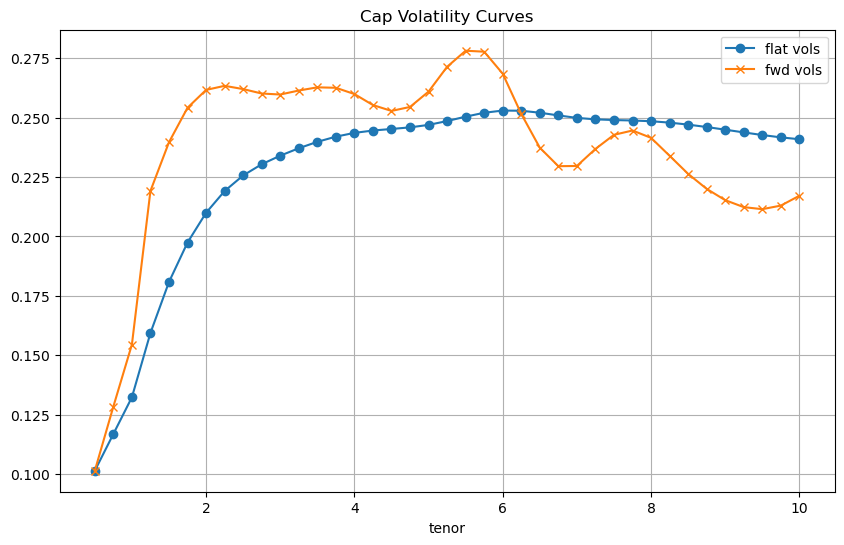

In [78]:
cap_curves[["flat vols", "fwd vols"]].plot(figsize=(10, 6), title="Cap Volatility Curves", grid=True, style=['-o', '-x'])

### 2.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency

In [88]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def blacks_formula(T, vol, strike, fwd, discount=1.0, isCall=True):

    if T <= 0 or vol <= 0:
        intrinsic = (fwd - strike) if isCall else (strike - fwd)
        return discount * max(intrinsic, 0.0)
    
    sigT = vol * np.sqrt(T)
    d1 = (np.log(fwd / strike)) / sigT + 0.5 * sigT
    d2 = d1 - sigT
    
    if isCall:
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    return val


In [ ]:
def price_floorlet(T_pay, vol, strike, fwd, discount, notional=100, freq=4):

    dt = 1.0 / freq
    T_expiry = T_pay - dt
    pv = notional * dt * blacks_formula(
        T_expiry, vol, strike, fwd, discount, isCall=False
    )
    return pv


T = 3.0
strike_3 = cap_curves.loc[T, 'swap rates']
fwd_3    = cap_curves.loc[T, 'forwards']
disc_3   = cap_curves.loc[T, 'discounts']
vol_3    = cap_curves.loc[T, 'fwd vols'] # For caplets/floorlets use fwd vols

single_floorlet_price = price_floorlet(
    T_pay=T, vol=vol_3, strike=strike_3,
    fwd=fwd_3, discount=disc_3,
    notional=100, freq=4
)
print(f"Single Floorlet paying at T={T:.2f} => price={single_floorlet_price:.6f}")


Single Floorlet paying at T=3.00 => price=0.146310


### 2.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.

In [ ]:
def price_floor(T_final, vol, strike, forwards, discounts, notional=100, freq=4):

    dt = 1.0 / freq
    floor_val = 0.0
    floorlets = pd.DataFrame()
    n_quarters = int(round(T_final * freq))
    for i in range(2, n_quarters + 1):  
        t_pay = dt * i
        if t_pay > T_final:
            break
        
        fwd_t    = forwards.loc[t_pay]    
        disc_t   = discounts.loc[t_pay]   
        floorlet = price_floorlet(
            T_pay=t_pay, vol=vol, strike=strike,
            fwd=fwd_t, discount=disc_t,
            notional=notional, freq=freq
        )
        floor_val += floorlet
        floorlets.loc[t_pay, 'floorlet'] = floorlet
    return floor_val, floorlets

T_floor = 3.0
K_floor = cap_curves.loc[T_floor, 'swap rates'] 
vol_floor = cap_curves.loc[T_floor, 'flat vols']  # For floor use flat vols

full_floor_price, floorlets = price_floor(
    T_final=T_floor, vol=vol_floor, strike=K_floor,
    forwards=cap_curves['forwards'], discounts=cap_curves['discounts']
)
print(f"Floor out to T={T_floor} => {full_floor_price:.6f}")


Floor out to T=3.0 => 1.133091


***

# 3. Stripping Caps

### Data

Continue with the file `data/cap_curves_2025-01-31.xlsx`.

### 3.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

Tenor,cap_price
0.50,0.015175
0.75,0.045982
1.00,0.093612
1.25,0.170663
1.50,0.266562
1.75,0.378443
2.00,0.503493
2.25,0.633188
2.50,0.770615
2.75,0.915246


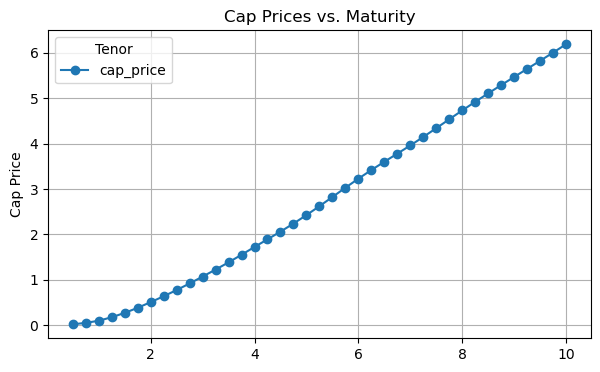

In [ ]:
def price_caplet(T_pay, vol, strike, fwd, discount, notional=100, freq=4):

    dt = 1.0 / freq
    T_expiry = T_pay - dt
    return notional * dt * blacks_formula(
        T_expiry, vol, strike, fwd, discount, isCall=True
    )

def price_cap(T_final, vol, strike, fwds, discounts, notional=100, freq=4):

    dt = 1.0 / freq
    cap_val = 0.0
    
    n_quarters = int(round(T_final * freq))
    for i in range(2, n_quarters + 1):
        t_pay = dt * i
        if t_pay > T_final:
            break
        F_t    = fwds.loc[t_pay]
        disc_t = discounts.loc[t_pay]
        cap_val += price_caplet(t_pay, vol, strike, F_t, disc_t, notional, freq)
    
    return cap_val

cap_maturities = np.arange(0.5, 10.1, 0.25)
cap_prices = {}
for T_cap in cap_maturities:
    vol_T = cap_curves.loc[T_cap, 'flat vols'] # Flat vol to price the Cap with capplets
    K_T   = cap_curves.loc[T_cap, 'swap rates']
    cap_val = price_cap(
        T_final=T_cap, vol=vol_T, strike=K_T,
        fwds=cap_curves['forwards'], discounts=cap_curves['discounts']
    )
    cap_prices[T_cap] = cap_val

cap_prices_df = pd.DataFrame({'cap_price': cap_prices}).T
cap_prices_df.index.name = 'Tenor'
cap_prices_df.sort_index(inplace=True)
cap_prices_df = cap_prices_df.T
display(cap_prices_df)

cap_prices_df.plot(style='-o', figsize=(7,4), grid=True, title="Cap Prices vs. Maturity")
plt.ylabel("Cap Price")
plt.show()


### 3.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

,flat_vol,fwd_vol,cap_price,caplet_price
Tenor,,,,
0.50,0.101500,0.101500,0.015175,0.015175
0.75,0.116946,0.128478,0.045982,0.025953
1.00,0.132391,0.154562,0.093612,0.039200
1.25,0.159421,0.219138,0.170663,0.056648
1.50,0.180856,0.239613,0.266562,0.080681
1.75,0.197446,0.254106,0.378443,0.101378
2.00,0.209941,0.261605,0.503493,0.120581
2.25,0.219090,0.263323,0.633188,0.114656
2.50,0.225643,0.261958,0.770615,0.129971


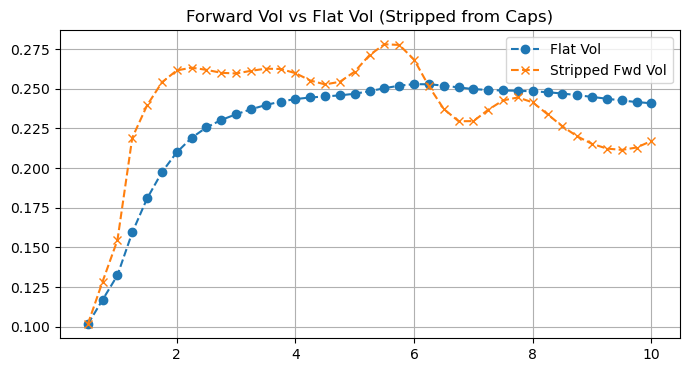

In [171]:
def blacks_formula(T, vol, strike, fwd, discount=1, isCall=True):
    sigT = vol * np.sqrt(T)
    d1 = np.log(fwd/strike)/sigT + 0.5*sigT
    d2 = d1 - sigT
    if isCall:
        return discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        return discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))

def price_caplet(T, vol, strike, fwd, discount, freq=4, notional=100):
    dt = 1.0/freq
    return notional * dt * blacks_formula(T, vol, strike, fwd, discount)

freq = 4
dt = 1.0/freq
notional = 100

first_cap_tenor = 2 * dt



sorted_tenors = sorted(cap_prices.keys())

forward_vols = {}
results = []

for i, t in enumerate(sorted_tenors):
    if t < first_cap_tenor:
        results.append((t, np.nan, np.nan, np.nan, np.nan))
        continue

    cap_price_current = cap_prices[t]   
    flat_vol = cap_curves.loc[t, 'flat vols']
    strike_t = cap_curves.loc[t, 'swap rates']
    fwd_t = cap_curves.loc[t, 'forwards']
    disc_t = cap_curves.loc[t, 'discounts']

    if np.isclose(t, first_cap_tenor):
        fwd_vol = flat_vol
        forward_vols[t] = fwd_vol
        caplet_price = cap_price_current
    else:
        previous_caplet_sum = 0.0
        for tj in sorted_tenors:
            if tj < first_cap_tenor or tj >= t:
                continue
            T_j = tj - dt
            fwd_vol_j = forward_vols[tj]  # previously computed forward vol for that period
            fwd_j = cap_curves.loc[tj, 'forwards']
            disc_j = cap_curves.loc[tj, 'discounts']
            price_j = price_caplet(T_j, fwd_vol_j, strike_t, fwd_j, disc_j, freq=freq, notional=notional)
            previous_caplet_sum += price_j

        new_caplet_price = cap_price_current - previous_caplet_sum

        t_prev = sorted_tenors[sorted_tenors.index(t) - 1]
        fwd_current = fwd_t
        disc_current = disc_t

        initial_guess = forward_vols[t_prev]
        wrapper = lambda vol: price_caplet(t_prev, vol, strike_t, fwd_current, disc_current, freq=freq, notional=notional) - new_caplet_price
        fwd_vol = fsolve(wrapper, initial_guess)[0]
        forward_vols[t] = fwd_vol
        caplet_price = new_caplet_price

    results.append((t, flat_vol, fwd_vol, cap_price_current, caplet_price))

df_stripped = pd.DataFrame(results, columns=['Tenor','flat_vol','fwd_vol','cap_price','caplet_price']).set_index('Tenor')

display(df_stripped)

plt.figure(figsize=(8,4))
plt.plot(df_stripped.index, df_stripped['flat_vol'], 'o--', label='Flat Vol')
plt.plot(df_stripped.index, df_stripped['fwd_vol'], 'x--', label='Stripped Fwd Vol')
plt.title("Forward Vol vs Flat Vol (Stripped from Caps)")
plt.grid(True)
plt.legend()
plt.show()


***